In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -q drive/MyDrive/SEAL_OR_NO_SEAL/interim.zip

In [3]:
!pip install pytorch-lightning torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 13.5 MB/s eta 0:00:00


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

random.seed(42)

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from torchmetrics import F1Score

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

from PIL import Image

from pathlib import Path

# Open images

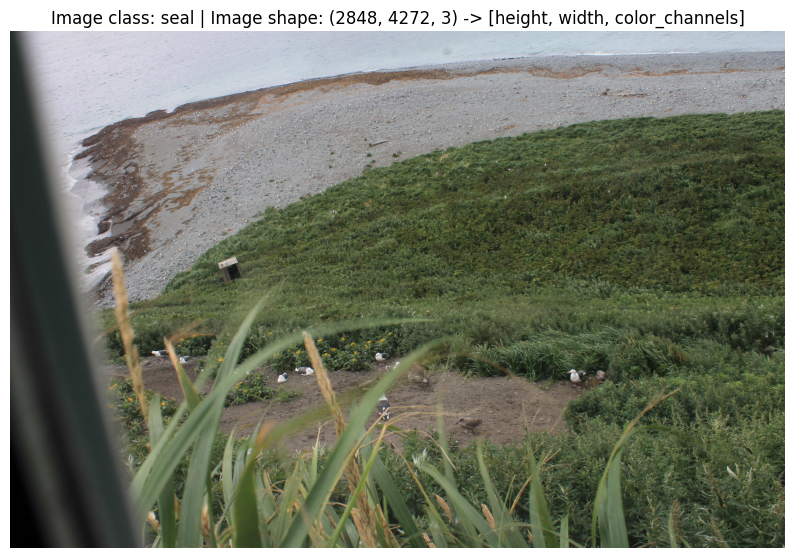

In [24]:
image_path_list = list(Path('./interim/train/seal').glob("*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [8]:
class SealDataset(Dataset):
    def __init__(self, images_direction, transform = None):

        self.paths = list(Path(images_direction).glob("*/*.jpg"))
        self.transform = transform

        self.classes, self.class_to_idx = (['no_seal', 'seal'], {'no_seal': 0, 'seal': 1})

    def load_image(self, index: int) -> Image.Image:
        """load image from path
           return:
              image
        """

        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = self.load_image(idx)
        class_name  = self.paths[idx].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [9]:
train_data = SealDataset('./interim/train', transform = train_transforms)
test_data = SealDataset('./interim/test', transform = test_transforms)
eval_data = SealDataset('./interim/eval', transform = test_transforms)

## display some images

In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes = None,
                          n: int = 10,
                          display_shape: bool = True):
    """display images from torch dataset
        args:
          dataset - torch dataset
          classes - images classes
          n - amount of samples
          display_shape - show title
    """
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        targ_image_adjust = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

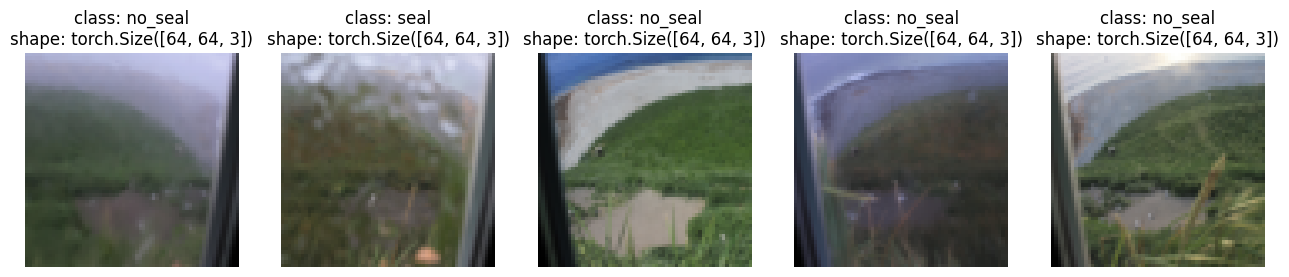

In [ ]:
display_random_images(train_data,
                      n=5,
                      classes=['no_seal', 'seal'])

# Classification model

In [21]:
class SealClassificationModel(pl.LightningModule):
    def __init__(self, learning_rate=3e-4):
        super().__init__()
        self.learning_rate = learning_rate
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.neural_net = models.resnet50(pretrained= True)
        self.neural_net.fc = torch.nn.Linear(2048,2)

        self.f1_train = F1Score(task='binary').to('cuda')
        self.f1_eval = F1Score(task='binary').to('cuda')
        self.f1_test = F1Score(task='binary').to('cuda')


    def forward(self, x):
        return self.neural_net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, verbose=False)
        return [optimizer], [scheduler]

    def training_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self(x)
        loss = self.loss_func(y_pred,y)
        f1score = self.f1_train(torch.argmax(y_pred, dim=1), y)
        self.log("train_loss" , loss, prog_bar=True)
        self.log("train_F1" , f1score, prog_bar=True)
        return loss

    def validation_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self(x)
        loss = self.loss_func(y_pred,y)
        f1score = self.f1_eval(torch.argmax(y_pred, dim=1), y)
        self.log("val_loss" , loss, prog_bar=True)
        self.log("val_F1" , f1score, prog_bar=True)
        return loss

    def test_step(self,batch,batch_idx):
        x,y = batch
        y_pred = self(x)
        loss = self.loss_func(y_pred,y)
        f1score = self.f1_test(torch.argmax(y_pred, dim=1), y)
        self.log("test_loss: " , loss, prog_bar=True)
        self.log("test_F1: " , f1score, prog_bar=True)
        return loss

In [19]:
torch.cuda.is_available()

True

In [20]:
from pytorch_lightning import Trainer
model = SealClassificationModel()
# data = SealDatasetPL()
trainer = Trainer(max_epochs=5)

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
eval_dataloader = DataLoader(eval_data, batch_size=64, shuffle=False)

trainer.fit(model, train_dataloader, eval_dataloader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [23]:
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

trainer.test(model, test_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_F1:          │    0.5361378192901611     │
│        test_loss:         │    0.7707907557487488     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss: ': 0.7707907557487488, 'test_F1: ': 0.5361378192901611}]

In [25]:
trainer.save_checkpoint("best_seal_model.ckpt", weights_only=True)